In [137]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Import users data
users = pd.read_csv('/Users/davidlichacz/Downloads/relax_challenge/takehome_users.csv',encoding='latin-1')
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [138]:
# Create new column that will be our target variable.  The default value is zero for not adopted.
users['adopted'] = 0

In [139]:
# Import engagement data.
engage = pd.read_csv('/Users/davidlichacz/Downloads/relax_challenge/takehome_user_engagement.csv')
engage.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [140]:
# Change time_stamp column to datetime as we will need to calculate using these.
engage['time_stamp'] = pd.to_datetime(engage['time_stamp'])

In [141]:
engage.visited.value_counts()

1    207917
Name: visited, dtype: int64

Each row of the engage table represents one visit.  We can drop this column as it provides no information.

In [142]:
engage = engage.drop(['visited'], axis=1)

In [143]:
# Extract list of all user ids.
user_list = users['object_id'].tolist()

In [144]:
for user in user_list:
    # Create list of time stamps for each user.
    time_list = engage[engage.user_id == user]['time_stamp'].tolist()
    # If there are less than two visits, the user is not adopted.
    if len(time_list) > 2:
        # Otherwise, calculate successive differences between three visits.
        diff_list = []
        for k in range(len(time_list) - 2):
            diff_list.append((time_list[k + 2] - time_list[k]).days)
            # If smallest difference is less than a week, the user is adopted.
            if min(diff_list) <= 7:
                users.at[user - 1, 'adopted'] = 1           

In [145]:
users.adopted.value_counts()

0    10344
1     1656
Name: adopted, dtype: int64

In [146]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
adopted                       12000 non-null int64
dtypes: float64(2), int64(5), object(4)
memory usage: 1.0+ MB


In [147]:
# There are some null values to deal with.

# For invited_by_user_id, let's convert the column to a boolean.
users['invited_by_user_id'] = users['invited_by_user_id'].apply(lambda x: 1 if not np.isnan(x) else 0)

# last_session_creation_time also contains null values, but this is not a field that will be useful for modeling, so we
# will drop this along with some other columns.
users = users.drop(['object_id', 'creation_time', 'name', 'email','last_session_creation_time', 'org_id'],axis=1)

In [148]:
# Create dummy variable for the creation_source column
users = pd.get_dummies(data=users,columns=['creation_source'])

In [151]:
users.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,invited_by_user_id,adopted,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,0,1,0,1,0,0,0,0
1,0,0,1,1,0,1,0,0,0
2,0,0,1,0,0,1,0,0,0
3,0,0,1,0,1,0,0,0,0
4,0,0,1,0,1,0,0,0,0


Since we have boolean variables, let's look at counts by adopted status for some of the variables.

In [150]:
import matplotlib.pyplot as plt
import seaborn as sns

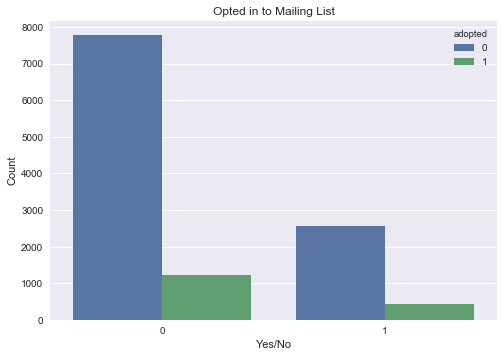

In [164]:
ax = sns.countplot(x="opted_in_to_mailing_list", hue="adopted", data=users)
plt.title('Opted in to Mailing List')
plt.xlabel('Mailing List (False/True)')
plt.ylabel('Count')
plt.show()

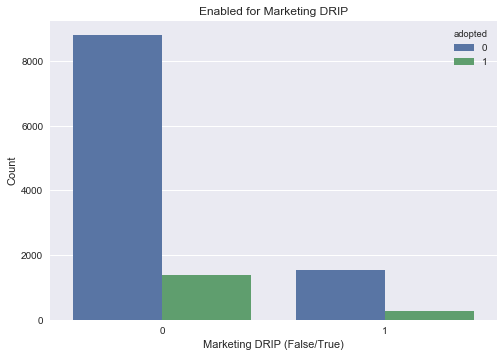

In [165]:
ax = sns.countplot(x="enabled_for_marketing_drip", hue="adopted", data=users)
plt.title('Enabled for Marketing DRIP')
plt.xlabel('Marketing DRIP (False/True)')
plt.ylabel('Count')
plt.show()

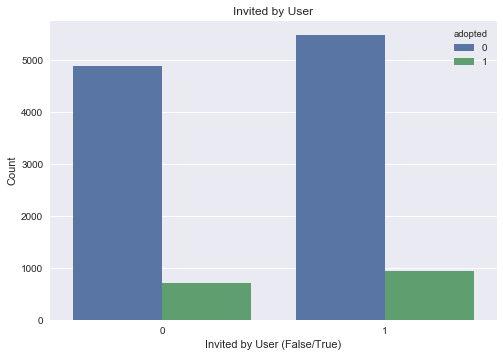

In [166]:
ax = sns.countplot(x="invited_by_user_id", hue="adopted", data=users)
plt.title('Invited by User')
plt.xlabel('Invited by User (False/True)')
plt.ylabel('Count')
plt.show()

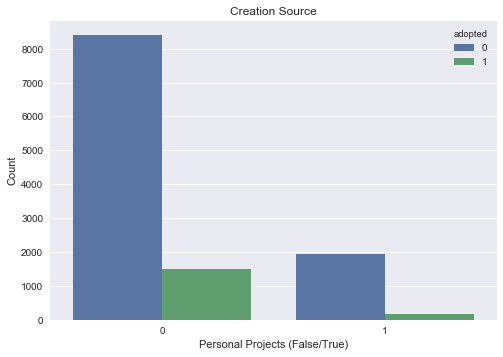

In [167]:
ax = sns.countplot(x="creation_source_PERSONAL_PROJECTS", hue="adopted", data=users)
plt.title('Creation Source')
plt.xlabel('Personal Projects (False/True)')
plt.ylabel('Count')
plt.show()

Looking at the plots, we have imbalanaced data, but all the proportions between adopted vs. not adopted seem consistent when comparing the two groups.  Let's fit a simple random forest model to test a level of accuracy and to get an idea of which features are most important.

In [168]:
# Separate target variable from other data.
X = users.drop(['adopted'], axis=1)
y = users['adopted']

In [169]:
# Fit a Random Forest model.
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Split the data into a training and test set.
Xlr, Xtestlr, ylr, ytestlr = train_test_split(X.values, y.values, random_state=5)

clf = RandomForestClassifier()
# Fit the model on the trainng data.
clf.fit(Xlr, ylr)
# Print the accuracy from the testing data.
print(accuracy_score(clf.predict(Xtestlr), ytestlr))

0.8593333333333333


/Users/davidlichacz/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


This simple model provides good accuracy.  Let's look at the most important features.

In [170]:
features = clf.feature_importances_
feature_importances = pd.DataFrame(features, index = X.columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)

In [171]:
feature_importances

,importance
creation_source_PERSONAL_PROJECTS,0.419178
creation_source_SIGNUP_GOOGLE_AUTH,0.196933
creation_source_GUEST_INVITE,0.111332
opted_in_to_mailing_list,0.087408
enabled_for_marketing_drip,0.071408
creation_source_ORG_INVITE,0.055599
invited_by_user_id,0.037117
creation_source_SIGNUP,0.021025
